In [9]:
import theano as th
from theano import tensor as T
import numpy as np

In [2]:
count=0
for i in range(1,11):
    count+=1
print count

10


In [3]:
i = T.iscalar('i')
results, updates = th.scan(fn=lambda previous_count: previous_count+1,
                            outputs_info=0,
                            n_steps=i)

Let's try and understand some of this. Firstly the integer variable i is there to tell scan how many times to iterate. Next we pass scan a function which it applies on each iteration, the first argument to the function is always the ***output from the previous call of the function***. We also have to tell scan what the outputs of the function should look like and initialize the count to zero. What we create are a variable results that will hold all of the function outputs, and updates, which are used as updates in a theano function.

In [4]:
f = th.function(inputs=[i], outputs=results, updates=updates)
print f(10)

[ 1  2  3  4  5  6  7  8  9 10]


Notice that it returns the result at each iteration. If you only care about the end result you could create a different function.

In [5]:
f = th.function(inputs=[i], outputs=results[-1], updates=updates)
print f(10)

10


This is worth doing since Theano is smart and will optimize by discarding the intermediate values once they are no longer needed. Next we will try a slightly trickier form of iteration. You have seen that scan stores the results of all the iterations, and so the function to be ***applied at each stage can accept as arugments any of the previous results***. This allows us to compute any recurrence relation we like, let's try everybody's favourite: the Fibonacci sequence.

In [6]:
i = T.iscalar('i') #Number of iterations.
x0 = T.ivector('x0') #Initializes the recurrence, since we need the previous 
                    #two terms in the Fibonacci sequence, we need an inital vector
                    #with two terms.
results, updates = th.scan(fn=lambda f_m_1,f_m_2: f_m_1+f_m_2,
                            outputs_info=[{'initial':x0, 'taps':[-2,-1]}],
                            n_steps=i)

In order to set this up, we need to provide scan with a bit more information. In the outputs_info argument we provide a list of dictionaries. We need to say what the ***inital variable*** is, in this case x0, and what arguments will be passed to the function at each step. The key ***'taps'*** is a list of indices to the results to be used as arguments, -1 and -2 mean the last and penultimate entries. By default, taps is set to [-1].

In [7]:
f=th.function(inputs=[i,x0], outputs=results, updates=updates)
print f(50, np.asarray([0,1], dtype=np.int32))

[          1           2           3           5           8          13
          21          34          55          89         144         233
         377         610         987        1597        2584        4181
        6765       10946       17711       28657       46368       75025
      121393      196418      317811      514229      832040     1346269
     2178309     3524578     5702887     9227465    14930352    24157817
    39088169    63245986   102334155   165580141   267914296   433494437
   701408733  1134903170  1836311903 -1323752223   512559680  -811192543
  -298632863 -1109825406]


I deliberately set the number of iterations high, you can see that when we get too large for an int32 to handle, we get overflow. So next let's try and some flow control to our loops, so we can end early if a condition is met, like say overflow.

In [8]:
def fib(f_m_1, f_m_2):
    ret= f_m_1+ f_m_2
    return ret, th.scan_module.until(ret <0)
i = T.iscalar('i') #Number of iterations.
x0 = T.ivector('x0') #Initializes the recurrence, since we need the previous 
                    #two terms in the Fibonacci sequence, we need an inital vector
                    #with two terms.
results, updates = th.scan(fn=fib,
                            outputs_info=[{'initial':x0, 'taps':[-2,-1]}],
                           
                            n_steps=i)

In [9]:
f=th.function(inputs=[i,x0], outputs=results, updates=updates)
print f(50, np.asarray([0,1], dtype=np.int32))

[          1           2           3           5           8          13
          21          34          55          89         144         233
         377         610         987        1597        2584        4181
        6765       10946       17711       28657       46368       75025
      121393      196418      317811      514229      832040     1346269
     2178309     3524578     5702887     9227465    14930352    24157817
    39088169    63245986   102334155   165580141   267914296   433494437
   701408733  1134903170  1836311903 -1323752223]


This conditional ending is a bit obscure, but you see that the key is to return two values from the function, the second being a th.scan_module.until(termination_condition).

Now let's do something a little less trival and implement the Newton-Raphson method for finding the zeros of a function with continuous second derivative. You can read about the method here: http://en.wikipedia.org/wiki/Newton%27s_method.

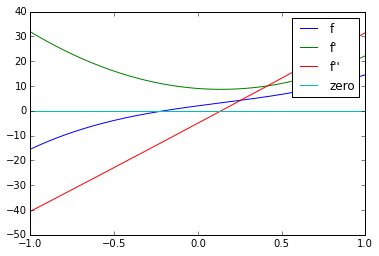

In [10]:
#First we create a symbolic variable.
x=T.dscalar('x')
f = 6*x**3 - 2*x**2 +9*x+ 1 + T.cos(x)
f_prime = T.grad(f,x)
f_prime_2 = T.grad(f_prime, x)

#Then the compiled theano functions for plotting.
F = th.function(inputs=[x], outputs=f)
F_prime = th.function(inputs=[x], outputs=f_prime)
F_prime_2 = th.function(inputs=[x], outputs=f_prime_2)

#Now let's make a plot.
xs = np.linspace(-1,1,1000)
y1 = [F(z) for z in xs]
y2 = [F_prime(z) for z in xs]
y3 = [F_prime_2(z) for z in xs]

import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(xs, y1, label='f')
plt.plot(xs, y2, label='f\'')
plt.plot(xs, y3, label='f\'\'')
plt.plot(xs, [0 for z in xs], label='zero')
plt.legend()

In [11]:
i=T.iscalar('k') #Number of iterations variable.

In [12]:
def update_func(func):
    #Argument func is a function producing the symbolic variable representation of the function we want to zero.
    def update(z):
        return z-func(z)/T.grad(func(z),z)
    return update
def f(z):
    return  6*z**3 - 2*z**2 +9*z+ 1 + T.cos(z)

In [13]:
results, updates = th.scan(fn=update_func(f),
                           outputs_info = x,
                           n_steps=i)

In [14]:
NR = th.function(inputs=[x,i], outputs=results[-1], updates=updates)

In [15]:
print NR(0.21, 30)

-0.204844163928


So it works, hurray! Just to point out however, there is not much point in using scan for something this quick, using a python for loop with compiled theano functions inside would be just as quick.

In [16]:
def loop(k):
    guess=0.21
    for i in range(k):
        guess= guess-F(guess)/F_prime(guess)
    return guess
loop(30)

-0.20484416392829791

In [17]:
%timeit 'loop(300)'

100000000 loops, best of 3: 16.2 ns per loop


In [18]:
%timeit 'NR(0.21, 300)'

100000000 loops, best of 3: 16.5 ns per loop


Now to finish, I will demonstrate scan's ability to iterate over tensors, like a list comprehension.

Let's try summing a vector first. In this case we pass scan a 'sequences' argument, the object we would like to iterate over.

***Note that we iterate over the first dimension of the tensor. For a vector this means the entries. For a matrix we iterate over the rows. And so on.***

To iterate over the columns of a matrix you would transpose it.

In [19]:
x=T.vector('x')
results, updates = th.scan(fn=lambda x_m_1, x0: x_m_1+x0,
                           outputs_info=0.0,
                           sequences=x)

In [20]:
X=np.asarray([1,1,3,5,11,-9], dtype=np.float32)
print sum(X)

12.0


In [21]:
print results[-1].eval({x:X})

12.0


###*We can see, in fn, for example, if it has 4 arguments x0, x1, x2, x3, x4, x5, x6 sequences=[x, y, z] are provided, and taps = [-2, -1], non_sequences = [ns0, ns1]. Then x0, x1, x2, x3, x4, x5, x6 represent the element from x, element from y, element from z, , -2 output element, -1 output element*, ns0, ns1

In [2]:
x=T.vector('x')
y = T.vector('y')
x0 = T.vector('x0')
ns0 = T.scalar('ns0')
ns1 = T.scalar('ns1')
i = T.iscalar('iter')
results, updates = th.scan(fn=lambda x0, y0, x_m_2, x_m_1, ns0, ns1: ns0 * x0 + ns1 * y0 + 2 * x_m_2 + 1 * x_m_1,
                           outputs_info=[{'initial':x0, 'taps':[-2,-1]}],
                           sequences=[x, y],
                           non_sequences = [ns0, ns1],
                           n_steps=i)

In [3]:
f = th.function(inputs=[i, x, y, x0, ns0, ns1], outputs=results, allow_input_downcast=True)

In [4]:
#xx = np.arange(10.0)
xx = np.zeros(10)
yy = np.arange(10.0)
nss0 = 2.
nss1 = 5.
#yy = np.zeros(10)
xx0 = np.array([2.0, 1.0])
ii = 5
f(ii, xx, yy, xx0, nss0, nss1)

array([   5.,   12.,   32.,   71.,  155.], dtype=float32)

In [6]:
updates

OrderedUpdates()

***Shared Variable***

We can encode shared variable into scan like the following. Pay attention to the datatype of the shared variable

In [10]:
w = th.shared(value=np.array(2).astype('float32'), allow_downcast=True)

In [11]:
x=T.vector('x')
y = T.vector('y')
x0 = T.vector('x0')
ns0 = T.scalar('ns0')
ns1 = T.scalar('ns1')
i = T.iscalar('iter')
results, updates = th.scan(fn=lambda x0, y0, x_m_2, x_m_1, ns0, ns1: w * ns0 * x0 + w * ns1 * y0 + 2 * x_m_2 + 1 * x_m_1,
                           outputs_info=[{'initial':x0, 'taps':[-2,-1]}],
                           sequences=[x, y],
                           non_sequences = [ns0, ns1],
                           n_steps=i)

In [4]:
f = th.function(inputs=[i, x, y, x0, ns0, ns1], outputs=results, allow_input_downcast=True)

In [5]:
#xx = np.arange(10.0)
xx = np.zeros(10)
yy = np.arange(10.0)
nss0 = 2.
nss1 = 5.
#yy = np.zeros(10)
xx0 = np.array([2.0, 1.0])
ii = 5
f(ii, xx, yy, xx0, nss0, nss1)

array([   5.,   17.,   47.,  111.,  245.], dtype=float32)

In [34]:
w.set_value(3)
f(ii, xx, yy, xx0, nss0, nss1)

array([   5.,   22.,   62.,  151.,  335.], dtype=float32)

####initialize with theano.shared
####initial in outputs_info can be tensor or shared, but not np.array

In [19]:
results, updates = th.scan(fn=lambda x0, y0, x_m_2, x_m_1, ns0, ns1: w * ns0 * x0 + w * ns1 * y0 + 2 * x_m_2 + 1 * x_m_1,
                           outputs_info=[{'initial':th.shared(np.array([2.0, 1.0])), 'taps':[-2,-1]}],
                           sequences=[x, y],
                           non_sequences = [ns0, ns1],
                           n_steps=i)

In [20]:
f = th.function(inputs=[i, x, y, ns0, ns1], outputs=results, allow_input_downcast=True)

In [21]:
f(ii, xx, yy, nss0, nss1)

array([   5.,   17.,   47.,  111.,  245.])

####cannot broadcast init?

In [44]:
w = th.shared(value=np.ones((2, 2)).astype('float32'), allow_downcast=True)
x=T.matrix('x')
y = T.matrix('y')
x0 = T.matrix('x0')
ns0 = T.vector('ns0')
ns1 = T.vector('ns1')
i = T.iscalar('iter')

results, updates = th.scan(fn=lambda x0, y0, x_m_1, ns0, ns1: w * ns0 * x0 + w * ns1 * y0 + 1 * x_m_1,
                           outputs_info=[{'initial':th.shared(np.ones((2, 2))), 'taps':[-1]}],
                           sequences=[x, y],
                           non_sequences = [ns0, ns1],
                           n_steps=i)
f = th.function(inputs=[i, x, y, ns0, ns1], outputs=results, allow_input_downcast=True)

In [45]:
#xx = np.arange(10.0)
xx = np.zeros((10,2))
yy = np.arange(20.0).reshape(10, 2)
nss0 = [2., 2.]
nss1 = [5., 5.]
ii = 5
f(ii, xx, yy, nss0, nss1)

array([[[   1.,    6.],
        [   1.,    6.]],

       [[  11.,   21.],
        [  11.,   21.]],

       [[  31.,   46.],
        [  31.,   46.]],

       [[  61.,   81.],
        [  61.,   81.]],

       [[ 101.,  126.],
        [ 101.,  126.]]])